# Visualization of Trained Model Results

This notebook provides visualizations and analysis for the outputs of trained models, including performance metrics, plots, confusion matrices, feature importances, and interactive figures to explore results.

1) Register existing envionment as a jupyter kernel **(Do this once within the activated virtual environment in the terminal)** \
`python -m ipykernel install --user --name project-venv --display-name "Python (Project Env)"`

2) Start Jupyter Notebook From Same Environment \
`python -m jupyter notebook`

### Troubleshooting

Code for troubleshooting environment settings or any misc settings

In [ ]:
import sys
print(sys.executable)

c:\Users\luoma\AppData\Local\Programs\Python\Python311\python.exe


### Required Libraries

Install & Import Required Libraries That Will Be Utilized Throughout The Notebook In The Virtual Environment.

In [1]:
### Plotting / Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

### Image Visualization Libraries
import cv2
from PIL import Image
import numpy as np

### Image Processing Libraries
from skimage import measure, morphology
from skimage.color import label2rgb

### Anomaly Map Visualization Libraries
from matplotlib import cm

### Metrics Libraries
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, confusion_matrix

### Misc Libraries
import plotly.express as px
import plotly.graph_objects as goz

## Visualizing Dataset
**MIIC** is a novel dataset of real microscopic images of integrated circuits (ICs), to benchmark the IAD algorithms. The MIIC dataset includes 25,160 normal and 116 anomalous high-resolution IC images obtained by ScanningElectron Microscopy (SEM). The SEM images are taken at the metal layer of a manufactured IC and are in gray-scale with a dimension of 512x512 pixels. For each image containing anomalies, we provide differ-ent types of annotations, including the bounding box and pixel-wise ground truth mask for them, which enables future research toward various computer vision applications.

#### Original Training Images
Sample displays of "non-anomalous" images used in the training for the DSR model.

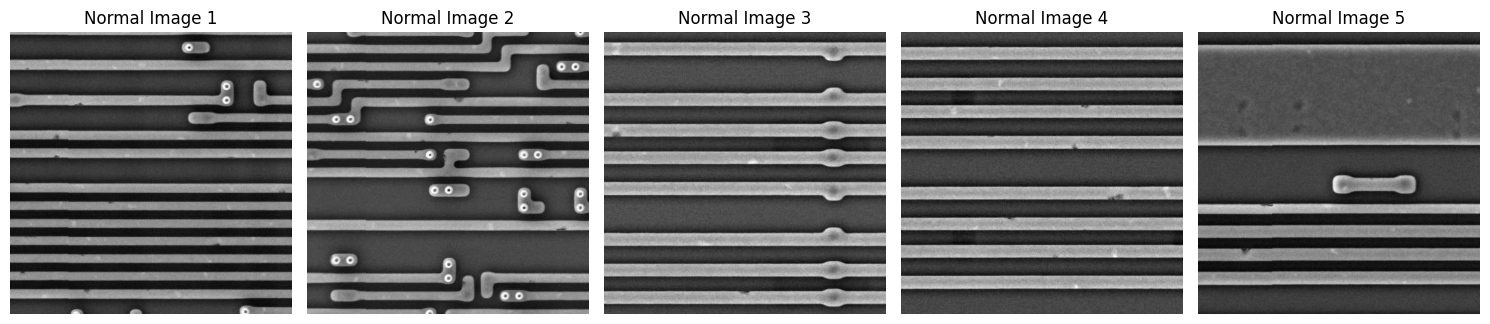

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

normal_image_paths = [
    "../data/train/normal/train_normal_04501.jpg",
    "../data/train/normal/train_normal_04541.jpg",
    "../data/train/normal/train_normal_04851.jpg",
    "../data/train/normal/train_normal_04918.jpg",
    "../data/train/normal/train_normal_05154.jpg",
]

images = [np.array(Image.open(p)) for p in normal_image_paths]

plt.figure(figsize=(15, 4))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"Normal Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


#### Non-anomalous Images
Sample displays of "anomalous" images that the DSR model should flag out

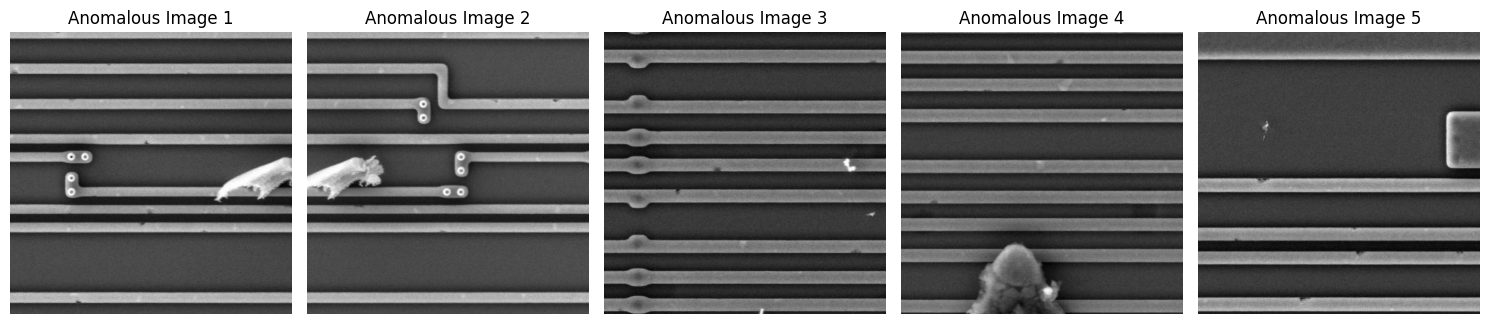

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

anomalous_image_paths = [
    "../data/test/anomalous/test_abnormal_00029.jpg",
    "../data/test/anomalous/test_abnormal_00042.jpg",
    "../data/test/anomalous/test_abnormal_00072.jpg",
    "../data/test/anomalous/test_abnormal_00009.jpg",
    "../data/test/anomalous/test_abnormal_00109.jpg",
]

images = [np.array(Image.open(p)) for p in anomalous_image_paths]

plt.figure(figsize=(15, 4))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"Anomalous Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## DSR Model Results (Small Sample)
Taking in a small sample size *(~10 images)*, display performance and sample results of anomalous and non-anomalous images passing through the trained DSR model


#### Sample Image Inputs
Equal mix of anomalous and non-anomalous images to be passed into the model


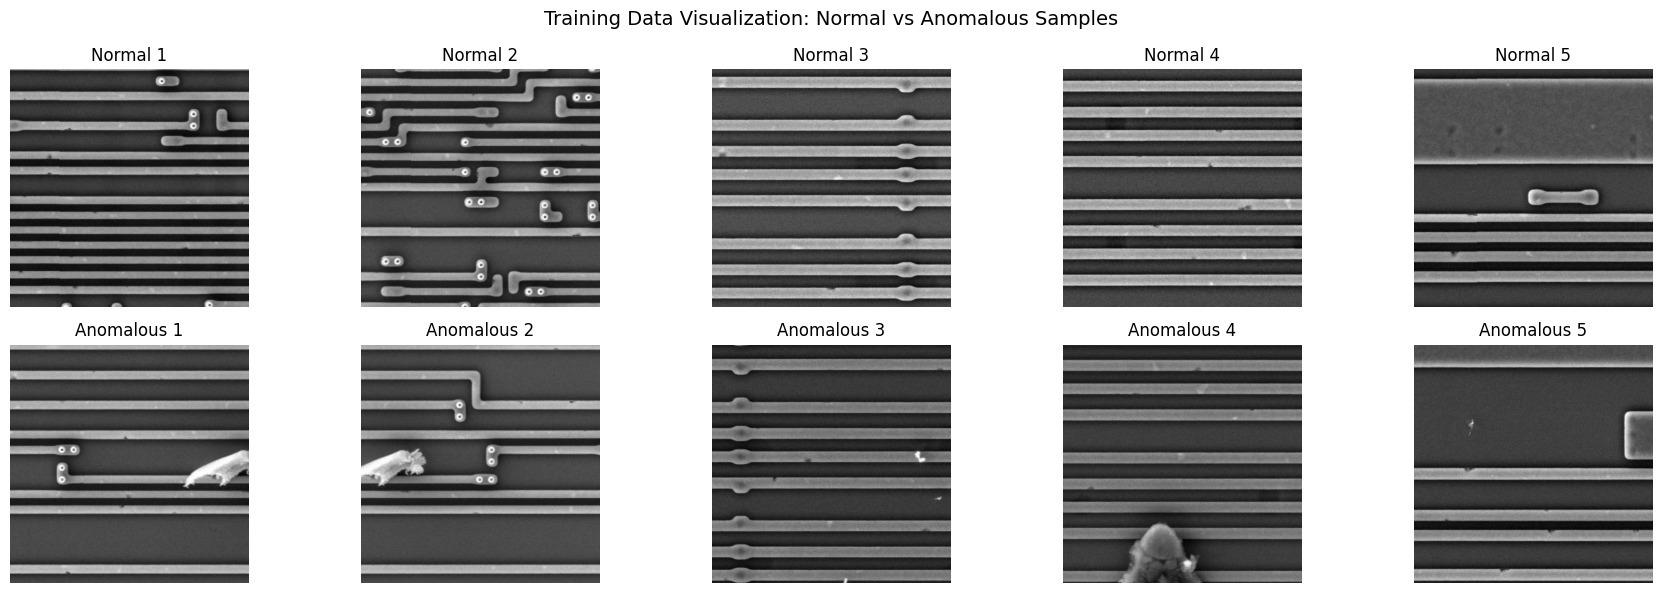

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Image Paths
anomalous_image_paths = [
    "../data/test/anomalous/test_abnormal_00029.jpg",
    "../data/test/anomalous/test_abnormal_00042.jpg",
    "../data/test/anomalous/test_abnormal_00072.jpg",
    "../data/test/anomalous/test_abnormal_00009.jpg",
    "../data/test/anomalous/test_abnormal_00109.jpg",
]

normal_image_paths = [
    "../data/train/normal/train_normal_04501.jpg",
    "../data/train/normal/train_normal_04541.jpg",
    "../data/train/normal/train_normal_04851.jpg",
    "../data/train/normal/train_normal_04918.jpg",
    "../data/train/normal/train_normal_05154.jpg",
]

# Load images
normal_images = [np.array(Image.open(p)) for p in normal_image_paths]
anomalous_images = [np.array(Image.open(p)) for p in anomalous_image_paths]

# Create a 2x5 grid
plt.figure(figsize=(18, 6))

# First row: Normal images
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(normal_images[i], cmap="gray")
    plt.title(f"Normal {i+1}")
    plt.axis("off")

# Second row: Anomalous images
for i in range(5):
    plt.subplot(2, 5, i + 6)   # +6 because second row starts at position 6
    plt.imshow(anomalous_images[i], cmap="gray")
    plt.title(f"Anomalous {i+1}")
    plt.axis("off")

plt.suptitle("Training Data Visualization: Normal vs Anomalous Samples", fontsize=14)
plt.tight_layout()
plt.show()


#### Create Custom Dataset For Testing

In [17]:
import os, shutil

selected_image_paths = normal_image_paths + anomalous_image_paths

tmp_dir = "../data/temp_infer/images"
os.makedirs(tmp_dir, exist_ok=True)

# (Optional) clear old files
for f in os.listdir(tmp_dir):
    os.remove(os.path.join(tmp_dir, f))

# copy in selected images
for p in selected_image_paths:
    shutil.copy(p, os.path.join(tmp_dir, os.path.basename(p)))



#### Run Inference & Visualize Results
- Load in trained model
- Predict selected images

In [60]:
# ------------------------ IMPORTS --------------------------------
from anomalib.data import Folder
from anomalib.models import Dsr
from anomalib.engine import Engine
import glob, os
import torch

# ------------------------ LOAD CONFIGS --------------------------------
MODEL_PATH = "../weights/dsr_large_sample_epoch=20.ckpt"

# ---- Ensure GPU Used When Available ----
if torch.cuda.is_available():
    torch.cuda.set_device(0)  # Set to the first GPU if available

# --- load trained model ---
model = Dsr.load_from_checkpoint(
    MODEL_PATH,
)

# --- create engine for testing ---
engine = Engine(
    logger = True,  # enable logging
    accelerator="gpu",  # use available accelerator (GPU/CPU)
    log_every_n_steps=10,
)

datamodule = Folder(
    name="temp_infer",
    root="../data/temp_infer",
    normal_dir="images",   # required argument
    normal_test_dir="images",
    abnormal_dir="images",
    val_split_mode="none",
    test_split_mode="none",
    eval_batch_size=1,
)

# Check if intended directory contains images
# img_dir = "../data/temp_infer/images"
# files = sorted(glob.glob(os.path.join(img_dir, "*.*")))
# print("Found", len(files), "files")
# print(files[:5])

preds = engine.predict(model=model, datamodule=datamodule, ckpt_path=MODEL_PATH)
# print(preds[0].keys())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at C:\Users\luoma\Documents\FYP\Encoder-Decoder\weights\dsr_large_sample_epoch=20.ckpt
c:\Users\luoma\Documents\FYP\Encoder-Decoder\.venv\Lib\site-packages\lightning\pytorch\trainer\call.py:283: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'train_loss_epoch', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\luoma\Documents\FYP\Encoder-Decoder\weights\dsr_large_sample_epoch=20.ckpt
c:\Users\luoma\Documents\FYP\Encoder-Decoder\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=Tr

Predicting: |          | 0/? [00:00<?, ?it/s]

In [81]:
image_number = 7  # Change this index to view different images from the batch
print(preds[image_number].keys())
print(preds[image_number]['image_path'])
print(preds[image_number]['gt_label'])
print(preds[image_number]['pred_score'])

['image', 'gt_label', 'gt_mask', 'mask_path', 'anomaly_map', 'pred_score', 'pred_mask', 'pred_label', 'explanation', 'image_path']
['C:\\Users\\luoma\\Documents\\FYP\\Encoder-Decoder\\data\\temp_infer\\images\\train_normal_04851.jpg']
tensor([True])
tensor([nan])


In [ ]:
# ------------------------ IMPORTS --------------------------------
from anomalib.data import Folder
from anomalib.models import Dsr
from anomalib.engine import Engine
import glob, os
import torch

# ------------------------ LOAD CONFIGS --------------------------------
MODEL_PATH = "../weights/dsr_large_sample_epoch=20.ckpt"

# ---- Ensure GPU Used When Available ----
if torch.cuda.is_available():
    torch.cuda.set_device(0)  # Set to the first GPU if available

# --- load trained model ---
model = Dsr.load_from_checkpoint(
    MODEL_PATH,
)

# --- create engine for testing ---
engine = Engine(
    logger = True,  # enable logging
    accelerator="gpu",  # use available accelerator (GPU/CPU)
    log_every_n_steps=10,
)

datamodule = Folder(
    name="temp_infer",
    root="../data/temp_infer",
    normal_dir="images",   # required argument
    normal_test_dir="images",
    abnormal_dir="images",
    val_split_mode="none",
    test_split_mode="none",
    eval_batch_size=1,
)

# Check if intended directory contains images
# img_dir = "../data/temp_infer/images"
# files = sorted(glob.glob(os.path.join(img_dir, "*.*")))
# print("Found", len(files), "files")
# print(files[:5])

preds = engine.predict(model=model, datamodule=datamodule, ckpt_path=MODEL_PATH)
# print(preds[0].keys())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at C:\Users\luoma\Documents\FYP\Encoder-Decoder\weights\dsr_large_sample_epoch=20.ckpt
c:\Users\luoma\Documents\FYP\Encoder-Decoder\.venv\Lib\site-packages\lightning\pytorch\trainer\call.py:283: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'train_loss_epoch', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\luoma\Documents\FYP\Encoder-Decoder\weights\dsr_large_sample_epoch=20.ckpt
c:\Users\luoma\Documents\FYP\Encoder-Decoder\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=Tr

Predicting: |          | 0/? [00:00<?, ?it/s]

#### Display anomalous & non-anomalous results
Load original image, as well as the anomaly map results and the final overlay

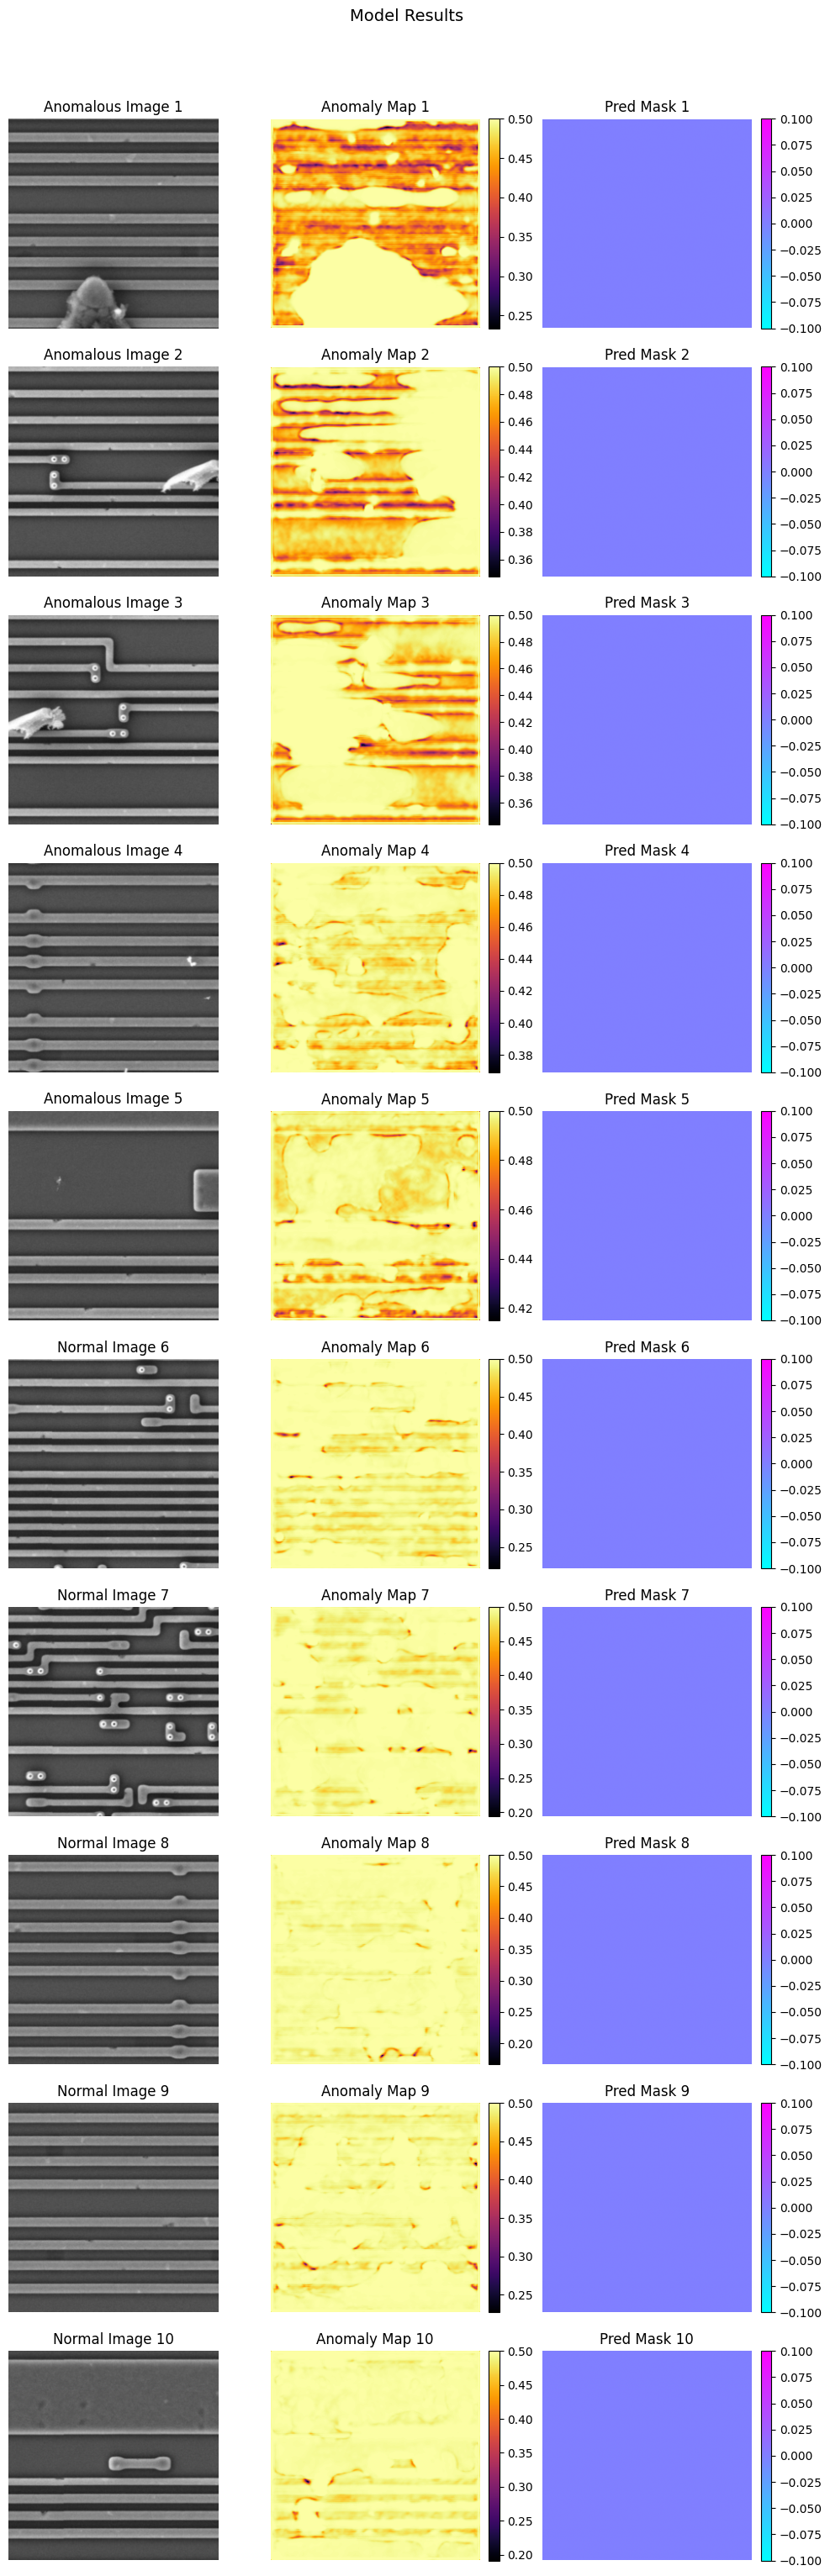

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def fetch(pred, key):
    # Try dict-style first
    if hasattr(pred, "__getitem__"):
        try:
            return pred[key]
        except Exception:
            pass
    # Then attribute-style
    return getattr(pred, key, None)

def to_imshow(x, idx=0, is_mask=False):
    if x is None:
        return None

    # torch -> cpu numpy
    if hasattr(x, "detach"):
        x = x.detach().cpu().numpy()
    else:
        x = np.array(x)

    # If batched (B,C,H,W) take one
    if x.ndim == 4:
        x = x[idx]  # -> (C,H,W)
    # If batched mask/map (B,H,W)
    elif x.ndim == 3 and x.shape[0] != x.shape[-1] and x.shape[0] != x.shape[1]:
        x = x[idx]

    # CHW -> HWC
    if x.ndim == 3 and x.shape[0] in (1, 3, 4):
        x = np.transpose(x, (1, 2, 0))

    if is_mask:
        if x.ndim == 3:
            x = x[..., 0]
        x = x.squeeze()

    return x

def plot_prediction(preds, idx=0):
    no_of_predictions = len(preds)

    # Create N rows, 3 columns
    fig, axes = plt.subplots(no_of_predictions, 3, figsize=(10, 3 * no_of_predictions))

    # If only 1 prediction, axes is 1D, make it 2D
    if no_of_predictions == 1:
        axes = np.array([axes])

    for i in range(no_of_predictions):
        image     = to_imshow(fetch(preds[i], "image"), idx=idx, is_mask=False)
        anomaly   = to_imshow(fetch(preds[i], "anomaly_map"), idx=idx, is_mask=True)
        pred_mask = to_imshow(fetch(preds[i], "pred_mask"), idx=idx, is_mask=True)

        # Check if image is anomalous or not
        header_prefix = "Anomalous" if "_abnormal_" in preds[i]['image_path'][0] else "Normal"

        # ---- Column 1: Image ----
        ax = axes[i, 0]
        if image is None:
            ax.text(0.5, 0.5, "image=None", ha="center", va="center")
        else:
            if image.ndim == 2:
                ax.imshow(image, cmap="gray")
            else:
                ax.imshow(image)
        ax.set_title(f"{header_prefix} Image {i+1}")
        ax.axis("off")

        # ---- Column 2: Anomaly Map ----
        ax = axes[i, 1]
        if anomaly is None:
            ax.text(0.5, 0.5, "anomaly_map=None", ha="center", va="center")
        else:
            im = ax.imshow(anomaly, cmap="inferno")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"Anomaly Map {i+1}")
        ax.axis("off")

        # ---- Column 3: Pred Mask ----
        ax = axes[i, 2]
        if pred_mask is None:
            ax.text(0.5, 0.5, "pred_mask=None", ha="center", va="center")
        else:
            im = ax.imshow(pred_mask, cmap="cool")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"Pred Mask {i+1}")
        ax.axis("off")

    plt.suptitle("Model Results", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

plot_prediction(preds, idx=0)

#### Results Metrics Display